In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [25]:
def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="autoencoder_2dim"):
   

    encoder, decoder = models
    features_test, target_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(features_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    target_test = target_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(target_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [20]:
(features_train, target_train), (features_test, target_test) = mnist.load_data()

In [21]:
# reshape to (28, 28, 1) and normalize input images
image_size = features_train.shape[1]
features_train = np.reshape(features_train, [-1, image_size, image_size, 1])
features_test = np.reshape(features_test, [-1, image_size, image_size, 1])
features_train = features_train.astype('float32') / 255
features_test = features_test.astype('float32') / 255

In [22]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

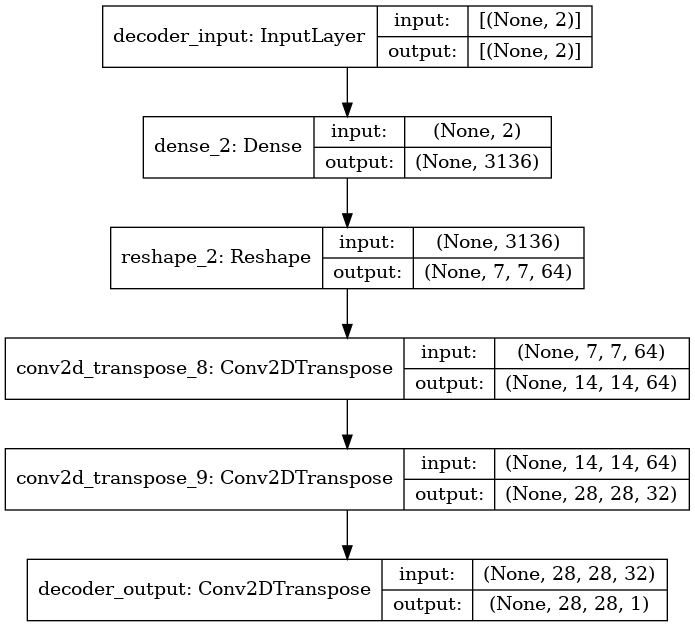

In [23]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 25090     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         65089     
Total params: 90,179
Trainable params: 90,179
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0409 - val_loss: 0.0417
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0409 - val_loss: 0.0415
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0409 - val_loss: 0.0415
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss:

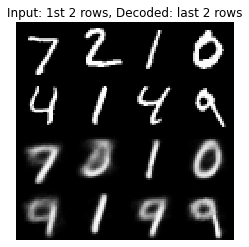

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(features_train,
                features_train,
                validation_data=(features_test, features_test),
                epochs=20,
                batch_size=batch_size)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(features_test)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([features_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# project the 2-dim latent on 2D space
models = (encoder, decoder)
data = (features_test, target_test)
plot_results(models, data,batch_size=batch_size,model_name="autoencoder-2dim")